#### By: Peyman Shahidi
#### Created: Oct 20, 2025
#### Last Edit: Oct 20, 2025

<br>

In [61]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [62]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots/anthropic_measure"

In [63]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [64]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [65]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,gpt4_exposure,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E2,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E2,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2


In [66]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


In [67]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]

In [68]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

merged_data.head()

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,task_normalized,task_name,automation,augmentation,label
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,NaN,NaN,direct or coordinate an organization's financi...,direct or coordinate an organization's financi...,0.35,0.57,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E0,E0,"confer with board members, organization offici...","confer with board members, organization offici...",0.25,0.61,Augmentation
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,analyze operations to evaluate performance of ...,analyze operations to evaluate performance of ...,0.31,0.66,Augmentation
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E0,"direct, plan, or implement policies, objective...",NaN,NaN,NaN,Manual
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,"prepare budgets for approval, including those ...",NaN,NaN,NaN,Manual


In [69]:
# # Reshuffle task assignments while preserving SOC hierarchy structure
# # Each occupation unit (O*NET-SOC Code + hierarchy levels) stays intact, but tasks are randomly reassigned
# # COMPLETELY UNRESTRICTED: Each task assigned to random occupation, no constraints on tasks per occupation

# # Create a copy of the data for reshuffling
# reshuffled_data = merged_data.copy()

# # Create SOC hierarchy levels with descriptive names from the O*NET-SOC Code
# reshuffled_data['soc_major_group'] = reshuffled_data['O*NET-SOC Code'].str[:2]
# reshuffled_data['soc_minor_group'] = reshuffled_data['O*NET-SOC Code'].str[:5] 
# reshuffled_data['soc_broad_occupation'] = reshuffled_data['O*NET-SOC Code'].str[:8]
# reshuffled_data['soc_detailed_occupation'] = reshuffled_data['O*NET-SOC Code']

# # Get unique occupation units (with all hierarchy levels intact)
# occupation_units = reshuffled_data[['O*NET-SOC Code', 'Occupation Title', 'soc_major_group', 
#                                    'soc_minor_group', 'soc_broad_occupation', 'soc_detailed_occupation']].drop_duplicates()

# print(f"Number of unique occupation units: {len(occupation_units):,}")

# # Get all unique tasks (each task appears only once)
# unique_tasks = reshuffled_data[['Task ID', 'Task Title', 'Task Type', 'gpt4_exposure', 
#                                'human_labels', 'task_normalized', 'task_name', 
#                                'automation', 'augmentation', 'label']].drop_duplicates()

# print(f"Number of unique tasks: {len(unique_tasks):,}")

# # Set random seed for reproducibility
# np.random.seed(42)

# # UNRESTRICTED ASSIGNMENT: Each task randomly assigned to any occupation unit
# # No constraints on how many tasks per occupation
# n_tasks = len(unique_tasks)
# n_occupations = len(occupation_units)

# # Random assignment: each task gets assigned to a completely random occupation
# random_occupation_indices = np.random.choice(n_occupations, size=n_tasks, replace=True)

# print(f"Assigning {n_tasks:,} tasks randomly across {n_occupations:,} occupation units")

# # Create the reshuffled dataset
# reshuffled_list = []

# for task_idx in range(n_tasks):
#     occ_idx = random_occupation_indices[task_idx]
    
#     # Get task information
#     task_row = unique_tasks.iloc[task_idx].to_dict()
    
#     # Get occupation information  
#     occ_row = occupation_units.iloc[occ_idx].to_dict()
    
#     # Combine them
#     combined_row = {**task_row, **occ_row}
#     reshuffled_list.append(combined_row)

# # Create the reshuffled DataFrame
# reshuffled_data = pd.DataFrame(reshuffled_list)

# print(f"Reshuffled dataset created with {len(reshuffled_data):,} rows")

# # Verify the reshuffling worked correctly
# print(f"\nOriginal dataset task distribution by occupation:")
# original_task_counts = merged_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
# print(f"Min tasks per occupation: {original_task_counts.min()}")
# print(f"Max tasks per occupation: {original_task_counts.max()}")
# print(f"Mean tasks per occupation: {original_task_counts.mean():.2f}")
# print(f"Std tasks per occupation: {original_task_counts.std():.2f}")

# print(f"\nReshuffled dataset task distribution by occupation:")
# reshuffled_task_counts = reshuffled_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
# print(f"Min tasks per occupation: {reshuffled_task_counts.min()}")
# print(f"Max tasks per occupation: {reshuffled_task_counts.max()}")
# print(f"Mean tasks per occupation: {reshuffled_task_counts.mean():.2f}")
# print(f"Std tasks per occupation: {reshuffled_task_counts.std():.2f}")

# # Count occupations with zero tasks
# zero_task_occupations = (reshuffled_task_counts == 0).sum()
# print(f"Occupations with zero tasks: {zero_task_occupations}")

# print(f"\nVerification:")
# print(f"Number of unique occupations preserved: {reshuffled_data['O*NET-SOC Code'].nunique() == merged_data['O*NET-SOC Code'].nunique()}")
# print(f"Number of unique tasks preserved: {reshuffled_data['Task ID'].nunique() == unique_tasks['Task ID'].nunique()}")
# print(f"Each task appears exactly once: {len(reshuffled_data) == len(unique_tasks)}")

# # Show SOC hierarchy column names
# print(f"\nSOC hierarchy columns created:")
# soc_columns = ['soc_major_group', 'soc_minor_group', 'soc_broad_occupation', 'soc_detailed_occupation']
# for col in soc_columns:
#     print(f"  {col}: {reshuffled_data[col].nunique():,} unique values")


# # Set reshuffled data as the final dataset
# merged_data = reshuffled_data.copy()

# # Show sample of reshuffled data
# print(f"\nSample of reshuffled data:")
# reshuffled_data.head()

In [70]:
# Drop the supplemental tasks
merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [71]:
# Only keep data for high AI-exposure major groups
high_ai_exposure_major_groups = ['13-0000', '15-0000', '19-0000', '21-0000', '23-0000', '25-0000', '27-0000', '41-0000', '43-0000']
merged_data = merged_data[merged_data['Major_Group_Code'].isin(high_ai_exposure_major_groups)].reset_index(drop=True)

In [72]:
# Create reduced dataset that keeps original column names only (no new column names will be added)
# Identify which of the desired columns exist in merged_data and keep them

# Detect wage column (keep original name if present)
wage_candidates = [c for c in merged_data.columns if 'wage' in c.lower()]
wage_col = wage_candidates[0] if wage_candidates else None
if wage_col is None:
    print('Note: no wage column found in the original dataset; wage will be omitted.')

# Detect time percentage column (keep original name if present)
time_candidates = [c for c in merged_data.columns if 'time' in c.lower() or 'pct' in c.lower() or 'percent' in c.lower()]
time_col = time_candidates[0] if time_candidates else None
if time_col is None:
    print('Note: no time percentage column found in the original dataset; time will be omitted.')

# Desired columns to keep (only include those that exist in merged_data)
desired_cols = [
    'Occupation Title',
    'O*NET-SOC Code',
    'Task Title',
    'label'
]
# Add wage/time cols only if detected
if wage_col is not None:
    desired_cols.append(wage_col)
if time_col is not None:
    desired_cols.append(time_col)
# Also include any existing SOC-level columns from the original dataset (do not create new names)
soc_candidates = [c for c in merged_data.columns if any(x in c.lower() for x in ['major', 'minor', 'broad', 'detailed', 'soc'])]
# Extend with unique SOC-like columns that are in the original dataset
for c in soc_candidates:
    if c not in desired_cols:
        desired_cols.append(c)
keep_cols = desired_cols

# Create the reduced dataset
reduced_dataset = merged_data[keep_cols].copy()

# Create AI indicator column: 0 if label is 'Manual', 1 otherwise
reduced_dataset['AI'] = (reduced_dataset['label'].astype(str).str.strip().ne('Manual')).astype(int)

# Change order of columns and have these columns appear first:
# ['Occupation Title', 'O*NET-SOC Code', 'Task Title', 'AI', 'Task_Time_Percentage', 'Hourly_Mean_Wage']
cols_order = ['Occupation Title', 'O*NET-SOC Code', 'Task Title', 'Task_Time_Percentage', 'Hourly_Mean_Wage', 'AI']
reduced_dataset = reduced_dataset[cols_order + [col for col in reduced_dataset.columns if col not in cols_order]]

reduced_dataset.head()

,Occupation Title,O*NET-SOC Code,Task Title,Task_Time_Percentage,Hourly_Mean_Wage,AI,label,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,"Agents and Business Managers of Artists, Perfo...",13-1011.00,"Collect fees, commissions, or other payments, ...",11.51,63.85,1,Automation,13-1011,13-0000,Business and Financial Operations Occupations,13-1000,Business Operations Specialists,13-1010,"Agents and Business Managers of Artists, Perfo...",13-1011,"Agents and Business Managers of Artists, Perfo..."
1,"Agents and Business Managers of Artists, Perfo...",13-1011.00,Confer with clients to develop strategies for ...,6.44,63.85,1,Augmentation,13-1011,13-0000,Business and Financial Operations Occupations,13-1000,Business Operations Specialists,13-1010,"Agents and Business Managers of Artists, Perfo...",13-1011,"Agents and Business Managers of Artists, Perfo..."
2,"Agents and Business Managers of Artists, Perfo...",13-1011.00,Develop contacts with individuals and organiza...,10.43,63.85,0,Manual,13-1011,13-0000,Business and Financial Operations Occupations,13-1000,Business Operations Specialists,13-1010,"Agents and Business Managers of Artists, Perfo...",13-1011,"Agents and Business Managers of Artists, Perfo..."
3,"Agents and Business Managers of Artists, Perfo...",13-1011.00,Schedule promotional or performance engagement...,7.87,63.85,0,Manual,13-1011,13-0000,Business and Financial Operations Occupations,13-1000,Business Operations Specialists,13-1010,"Agents and Business Managers of Artists, Perfo...",13-1011,"Agents and Business Managers of Artists, Perfo..."
4,"Agents and Business Managers of Artists, Perfo...",13-1011.00,"Negotiate with managers, promoters, union offi...",9.07,63.85,0,Manual,13-1011,13-0000,Business and Financial Operations Occupations,13-1000,Business Operations Specialists,13-1010,"Agents and Business Managers of Artists, Perfo...",13-1011,"Agents and Business Managers of Artists, Perfo..."


In [73]:
time_col = 'Task_Time_Percentage'
# Ensure time_col is numeric
reduced_dataset[time_col] = pd.to_numeric(reduced_dataset[time_col], errors='coerce').fillna(0)
# Aggregate
agg_manual = reduced_dataset[reduced_dataset['AI'] == 0].groupby('Occupation Title')[time_col].sum().rename('manual_time')
agg_ai = reduced_dataset[reduced_dataset['AI'] == 1].groupby('Occupation Title')[time_col].sum().rename('ai_time')
occupation_level = pd.concat([agg_manual, agg_ai], axis=1).fillna(0).reset_index()

# Show the occupation-level dataset
print('Occupation-level dataset sample:')
occupation_level.head()

Occupation-level dataset sample:


,Occupation Title,manual_time,ai_time
0,Accountants and Auditors,81.29,15.99
1,Actors,35.71,61.24
2,Actuaries,72.11,22.49
3,Adapted Physical Education Specialists,97.20,2.80
4,"Administrative Law Judges, Adjudicators, and H...",67.70,26.19


Saved scatter to ../writeup/plots/anthropic_measure/task_count_vs_ai_time_sum_scatter_binned.png


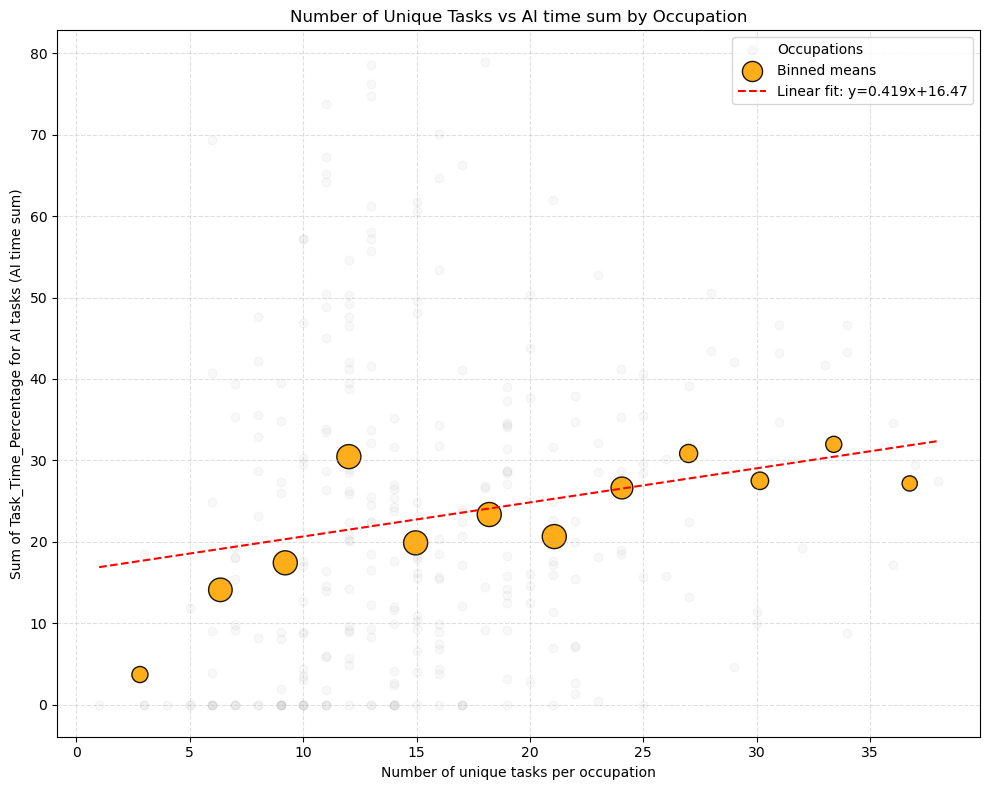

In [74]:
# Scatter: Sum of Task_Time_Percentage on AI tasks (y) vs number of unique tasks (x) per occupation
if 'reduced_dataset' not in globals():
    print("reduced_dataset not found. Please run the data preparation cells before this cell.")
else:
    task_id_col = 'Task Title'

    # Find time column (e.g., 'Task_Time_Percentage' or similar)
    time_cols = [c for c in reduced_dataset.columns if 'time' in c.lower() or 'pct' in c.lower() or 'percent' in c.lower()]
    if len(time_cols) == 0:
        print('No time percentage column found in reduced_dataset; cannot compute ai time sums.')
    else:
        time_col = time_cols[0]
        # Ensure numeric
        reduced_dataset[time_col] = pd.to_numeric(reduced_dataset[time_col], errors='coerce').fillna(0)

        # Compute number of unique tasks per occupation
        counts = reduced_dataset.groupby('Occupation Title')[task_id_col].nunique().rename('task_count')

        # Compute sum of time percentage over AI tasks per occupation
        ai_time_sum = reduced_dataset[reduced_dataset['AI'] == 1].groupby('Occupation Title')[time_col].sum().rename('ai_time_sum')

        # Combine
        occ_summary = pd.concat([counts, ai_time_sum], axis=1).fillna(0)

        # Defensive: ensure numeric
        occ_summary['ai_time_sum'] = pd.to_numeric(occ_summary['ai_time_sum'], errors='coerce').fillna(0)

        # Base scatter with low opacity (occupations)
        plt.figure(figsize=(10, 8))
        plt.scatter(occ_summary['task_count'], occ_summary['ai_time_sum'], color='gray', alpha=0.05, s=40, label='Occupations')

        # Add binned scatter (bin by task_count)
        n_bins = 12
        try:
            occ_summary['task_bin'] = pd.cut(occ_summary['task_count'], bins=n_bins)
        except Exception:
            occ_summary['task_bin'] = pd.qcut(occ_summary['task_count'], q=min(n_bins, occ_summary['task_count'].nunique()), duplicates='drop')

        bin_stats = occ_summary.groupby('task_bin').agg(
            task_count_mean=('task_count', 'mean'),
            ai_time_sum_mean=('ai_time_sum', 'mean'),
            ai_time_sum_median=('ai_time_sum', 'median'),
            count=('task_count', 'size')
        ).reset_index()

        # Compute marker sizes: sqrt scaling and cap max size
        base_marker_scale = 60
        marker_sizes = np.sqrt(bin_stats['count']) * base_marker_scale
        max_marker = 300
        marker_sizes = np.clip(marker_sizes, 20, max_marker)

        # Plot binned points (mean) with size reflecting sqrt(count) and higher opacity
        plt.scatter(bin_stats['task_count_mean'], bin_stats['ai_time_sum_mean'],
                    s=marker_sizes, color='orange', alpha=0.9, edgecolors='k', label='Binned means')

        # Fit and plot linear regression on the original points (robust to zeros)
        x = occ_summary['task_count'].values
        y = occ_summary['ai_time_sum'].values
        # Only use finite values
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() > 1:
            coeffs = np.polyfit(x[mask], y[mask], deg=1)
            x_line = np.linspace(x.min(), x.max(), 200)
            y_line = np.polyval(coeffs, x_line)
            plt.plot(x_line, y_line, color='red', linestyle='--', linewidth=1.5, label=f'Linear fit: y={coeffs[0]:.3f}x+{coeffs[1]:.2f}')

        plt.xlabel('Number of unique tasks per occupation')
        plt.ylabel(f"Sum of {time_col} for AI tasks (AI time sum)")
        plt.title('Number of Unique Tasks vs AI time sum by Occupation')
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.legend()

        plt.tight_layout()
        try:
            plt.savefig(f"{output_plot_path}/task_count_vs_ai_time_sum_scatter_binned.png", dpi=300)
            print(f"Saved scatter to {output_plot_path}/task_count_vs_ai_time_sum_scatter_binned.png")
        except Exception as e:
            print(f"Could not save plot: {e}")

        plt.show()

Wage column used: Hourly_Mean_Wage
Sample of occupation-wage-task_count dataset:


,Occupation Title,task_count,wage_mean
180,Models,1,33.03
208,"Postal Service Mail Sorters, Processors, and P...",3,27.09
265,Telephone Operators,3,20.24
127,Government Property Inspectors and Investigators,3,38.55
71,"Credit Authorizers, Checkers, and Clerks",4,24.22


Saved occ_wage_tasks to ../data/computed_objects/occ_wage_tasks.csv
Saved scatter to ../writeup/plots/anthropic_measure/task_count_vs_wage_scatter_binned.png
Saved scatter to ../writeup/plots/anthropic_measure/task_count_vs_wage_scatter_binned.png


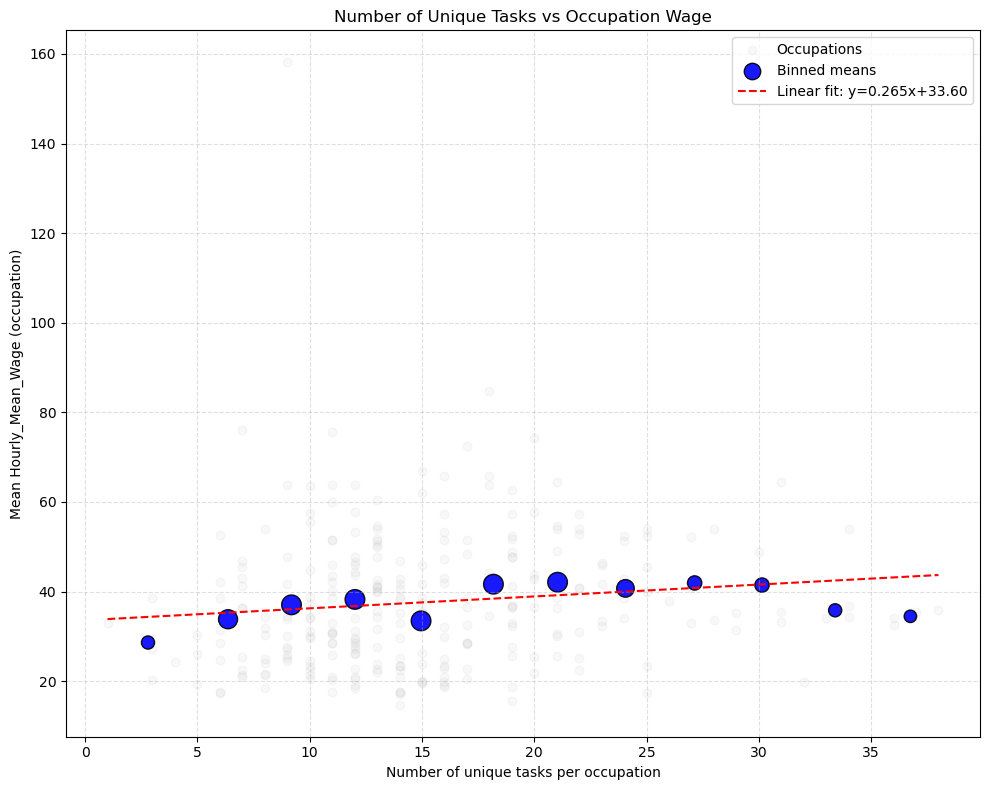

In [75]:
# Create occupation-wage-task_count dataset and plot wage vs number of unique tasks
if 'reduced_dataset' not in globals():
    print("reduced_dataset not found. Please run the data preparation cells before this cell.")
else:
    task_id_col = 'Task Title'

    # Detect wage-like column
    wage_candidates = [c for c in reduced_dataset.columns if any(k in c.lower() for k in ['wage', 'salary', 'hour'])]
    if not wage_candidates:
        print('No wage-like column found in reduced_dataset. Please add a wage column to proceed.')
    else:
        wage_col = wage_candidates[0]
        # coerce to numeric
        reduced_dataset[wage_col] = pd.to_numeric(reduced_dataset[wage_col], errors='coerce')

        # Build dataset: occupation, wage (mean), task count
        occ_wage_tasks = reduced_dataset.groupby('Occupation Title').agg(
            task_count=(task_id_col, 'nunique'),
            wage_mean=(wage_col, 'mean')
        ).reset_index()

        # Drop occupations with missing wage
        occ_wage_tasks = occ_wage_tasks[occ_wage_tasks['wage_mean'].notna()].sort_values('task_count')

        print(f"Wage column used: {wage_col}")
        print('Sample of occupation-wage-task_count dataset:')
        display(occ_wage_tasks.head())

        # Save dataset for later use
        try:
            occ_wage_tasks.to_csv(f"{output_data_path}/occ_wage_tasks.csv", index=False)
            print(f"Saved occ_wage_tasks to {output_data_path}/occ_wage_tasks.csv")
        except Exception as e:
            print(f"Could not save occ_wage_tasks: {e}")

        # Plot: task_count (x) vs wage_mean (y) 
        plt.figure(figsize=(10, 8))
        plt.scatter(occ_wage_tasks['task_count'], occ_wage_tasks['wage_mean'], color='gray', alpha=0.05, s=40, label='Occupations')

        # Binned scatter
        n_bins = 12
        try:
            occ_wage_tasks['task_bin'] = pd.cut(occ_wage_tasks['task_count'], bins=n_bins)
        except Exception:
            occ_wage_tasks['task_bin'] = pd.qcut(occ_wage_tasks['task_count'], q=min(n_bins, occ_wage_tasks['task_count'].nunique()), duplicates='drop')

        bin_stats = occ_wage_tasks.groupby('task_bin').agg(
            task_count_mean=('task_count', 'mean'),
            wage_mean_bin=('wage_mean', 'mean'),
            count=('task_count', 'size')
        ).reset_index()

        # Compute marker sizes (sqrt scale, smaller base and cap)
        base_marker_scale = 40
        marker_sizes = np.sqrt(bin_stats['count']) * base_marker_scale
        marker_sizes = np.clip(marker_sizes, 20, 200)

        plt.scatter(bin_stats['task_count_mean'], bin_stats['wage_mean_bin'], s=marker_sizes,
                    color='blue', alpha=0.9, edgecolors='k', label='Binned means')

        # Linear regression fit
        x = occ_wage_tasks['task_count'].values
        y = occ_wage_tasks['wage_mean'].values
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() > 1:
            coeffs = np.polyfit(x[mask], y[mask], deg=1)
            x_line = np.linspace(x.min(), x.max(), 200)
            y_line = np.polyval(coeffs, x_line)
            plt.plot(x_line, y_line, color='red', linestyle='--', linewidth=1.5, label=f'Linear fit: y={coeffs[0]:.3f}x+{coeffs[1]:.2f}')

        plt.xlabel('Number of unique tasks per occupation')
        plt.ylabel(f"Mean {wage_col} (occupation)")
        plt.title('Number of Unique Tasks vs Occupation Wage')
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.legend()

        plt.tight_layout()
        try:
            plt.savefig(f"{output_plot_path}/task_count_vs_wage_scatter_binned.png", dpi=300)
            print(f"Saved scatter to {output_plot_path}/task_count_vs_wage_scatter_binned.png")
        except Exception as e:
            print(f"Could not save plot: {e}")

        plt.show()